In [ ]:
# Line magics
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/dataCovid/"
print(PATH)

Mounted at /content/drive
/content/drive/MyDrive/dataCovid/


In [ ]:
ls ../content/drive/MyDrive/dataCovid/

Covid19/  Normal/  Pneumonia/


In [ ]:
!pip install pretrainedmodels
!pip install "torch==1.4" "torchvision==0.5.0"
!curl -s https://course.fast.ai/setup/colab | bash

     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=e1bdab90c73002ff0b9262653f352cd2d1f13c8c694e9b1706e407acfa9dd53d
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 44.1MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [ ]:
# import modules
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from fastai import *
from fastai.vision import *
from pathlib import Path
import pretrainedmodels

import torchvision
from utils import *

In [ ]:
def lr_find():
    learn.lr_find()
    learn.recorder.plot()

In [ ]:
def confusion_matrix(figsize=(3,3)):
    preds,y,losses = learn.get_preds(with_loss=True)
    interp = ClassificationInterpretation(learn, preds, y, losses)
    interp.plot_confusion_matrix(figsize=figsize)
    

In [ ]:
# path = Path('../data')
train_path = f'{PATH}/'


In [ ]:
print(os.listdir(PATH))

In [ ]:
fnames = get_image_files(train_path+ "Covid19")
fnames[:5]

torch.Size([3, 2000, 2000])


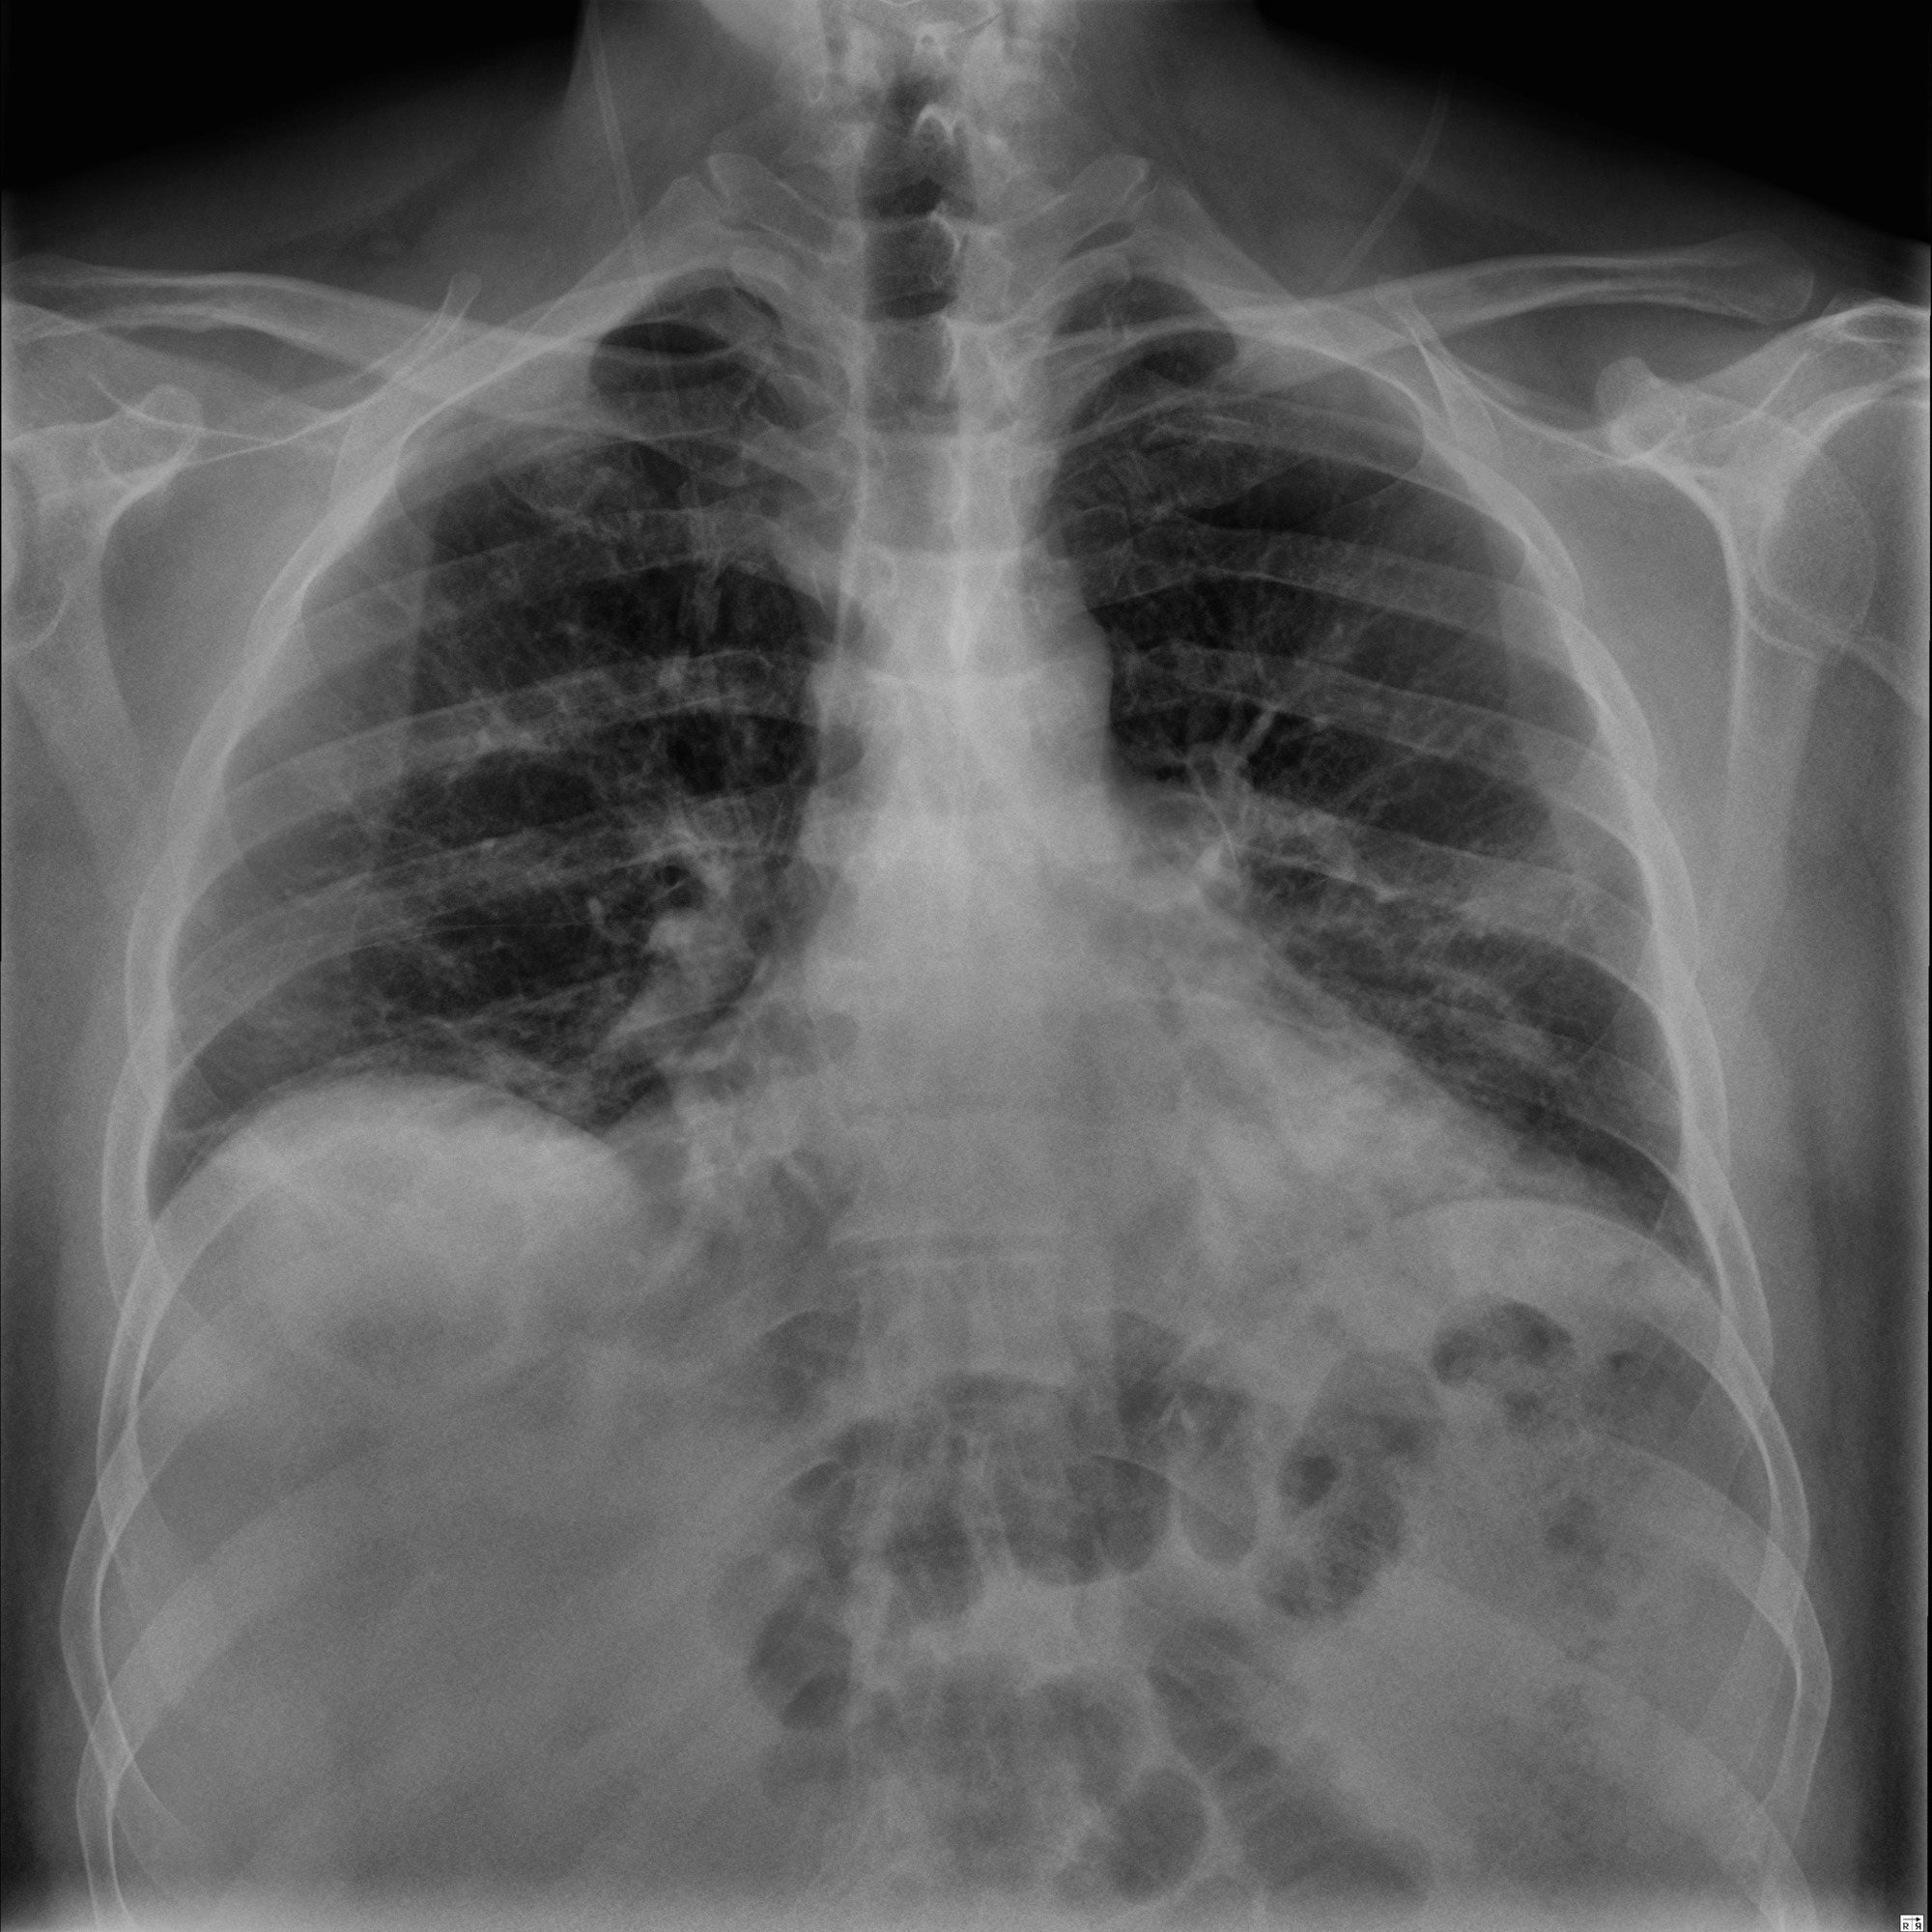

In [ ]:
img = open_image(fnames[0])
print(img.shape)
img

In [ ]:
# set batch size
bs=64
np.random.seed(99)
sz = 64

In [ ]:
def get_data(sz = 200,bs=32):
    tfms = get_transforms(flip_vert = False, max_zoom = 0.7)
    data = ImageDataBunch.from_folder(PATH,train=PATH, valid_pct = 0.2, ds_tfms=tfms, bs=bs, size=sz)
    data.normalize(imagenet_stats)
    return data

In [ ]:
data = get_data(sz = int(64*1.3), bs =64)

In [ ]:
data.show_batch(3)

In [ ]:
data.classes

In [ ]:
pd.DataFrame({'models':pretrainedmodels.model_names})

In [ ]:
def resnext50(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

In [ ]:
arch_summary(resnext50)

In [ ]:
metrics = [accuracy]
learn = create_cnn(data, resnext50, pretrained=False,metrics = metrics,
                   cut=-2, split_on=lambda m: (m[0][5], m[1]),model_dir='../models/')

In [ ]:
lr_find()

In [ ]:
learn.freeze()
learn.fit_one_cycle(5, max_lr = slice(1e-02, 1e-01))

In [ ]:
learn.unfreeze()
lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10,max_lr = slice(1e-06,2e-03))

In [ ]:
confusion_matrix((10,10))

In [ ]:
learn.save('asl_resnext50_64')

In [ ]:
learn.load('asl_resnext50_64')

In [ ]:
learn.freeze()
learn.data = get_data(sz=128,bs =64)
lr_find()

In [ ]:
learn.fit_one_cycle(4,max_lr = slice(1e-02))

In [ ]:
learn.unfreeze()
lr_find()

In [ ]:
learn.fit_one_cycle(10,max_lr = slice(1e-06,2e-04))

In [ ]:
learn.save('asl_resnext50_128')

In [ ]:
learn.load('asl_resnext50_128')

In [ ]:
confusion_matrix((10,10))

In [ ]:
learn.data = get_data(sz=200)

In [ ]:
learn.freeze()


In [ ]:
lr_find()

In [ ]:
learn.fit_one_cycle(4,max_lr = slice(1e-04,2e-02))

In [ ]:
learn.unfreeze()
lr_find()

In [ ]:
learn.fit_one_cycle(4,max_lr = slice(1e-06,2e-04))

In [ ]:
learn.fit_one_cycle(10,max_lr = slice(1e-06,2e-04))

In [ ]:
learn.save('asl_resnext50_250')

In [ ]:
learn.load('asl_resnext50_250')

Learner(data=ImageDataBunch;

Train: LabelList (1074 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
Normal,Normal,Normal,Normal,Normal
Path: /content/drive/MyDrive/dataCovid;

Valid: LabelList (268 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
Pneumonia,Normal,Normal,Pneumonia,Normal
Path: /content/drive/MyDrive/dataCovid;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(

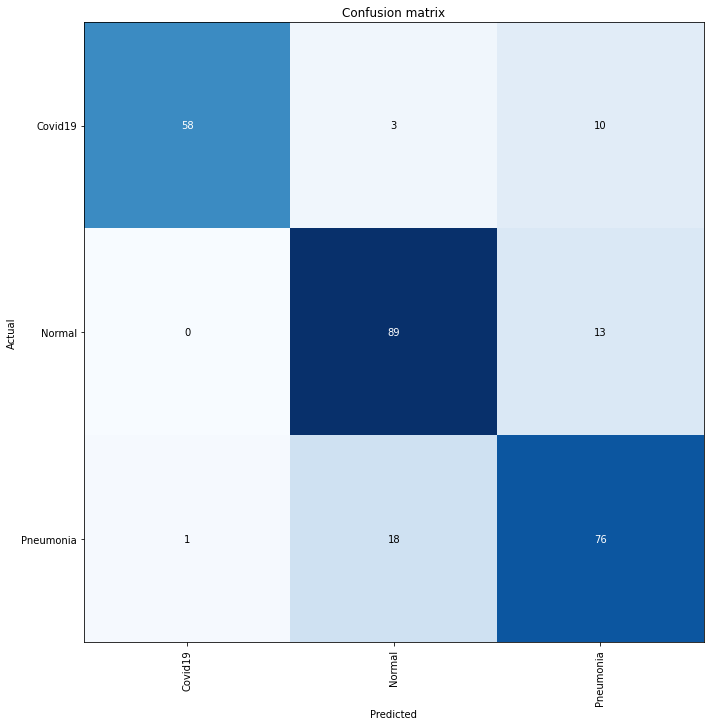

In [ ]:
confusion_matrix((10,10))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

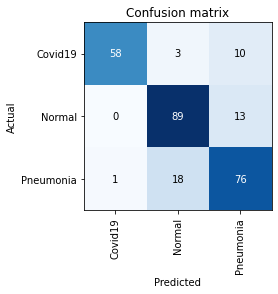

In [ ]:

interp.plot_confusion_matrix()

In [ ]:
learn.export(file = Path("/content/drive/MyDrive/export.pkl"))

In [ ]:
img = open_image(f'{path}/train/A/A1.jpg')
print(img.shape)
img

In [ ]:
pred,_,_ = learn.predict(img)
pred

In [ ]:
fnames = get_image_files(train_path+'B')
img = open_image(fnames[0])
print(img.shape)
img

In [ ]:
fnames = get_image_files(train_path+'B')
img = open_image(fnames[0])
print(img.shape)
img

In [ ]:
fnames = get_image_files(train_path+'C')
img = open_image(fnames[0])
print(img.shape)
img


In [ ]:
pred,_,_ = learn.predict(img)
pred

In [ ]:
fnames = get_image_files(train_path+'Y')
img = open_image(fnames[10])
print(img.shape)
img



In [ ]:
pred,_,_ = learn.predict(img)
pred

In [ ]:

img = open_image('../data/f1.jpg')
print(img.shape)
img



In [ ]:
pred,_,_ = learn.predict(img)
pred

In [ ]:
import cv2
img = cv2.imread('../data/f.jpg')
img = cv2.resize(img,(250,250))
cv2.imwrite('../data/f1.jpg',img)
